In [1]:
import os
import warnings
import re
from string import digits


import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from kaggle_datasets import KaggleDatasets
import transformers
import traitlets
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from tokenizers import BertWordPieceTokenizer
from sklearn.metrics import roc_auc_score

warnings.simplefilter("ignore")

## Хелперы

In [2]:
def fast_encode(texts, tokenizer, chunk_size=256, maxlen=512):
    tokenizer.enable_truncation(max_length=maxlen)
    tokenizer.enable_padding(max_length=maxlen)
    all_ids = []
    
    for i in tqdm(range(0, len(texts), chunk_size)):
        text_chunk = texts[i:i+chunk_size].tolist()
        encs = tokenizer.encode_batch(text_chunk)
        all_ids.extend([enc.ids for enc in encs])
    
    return np.array(all_ids)

In [3]:
def build_model(transformer, loss='binary_crossentropy', max_len=512):
    """Подгоняем преднатренированную модель под нужную единицу измерения"""
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    x = tf.keras.layers.Dropout(0.5)(cls_token)
    out = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=input_word_ids, outputs=out)
    model.compile(Adam(lr=3e-5), loss=loss, metrics=[tf.keras.metrics.AUC()])
    
    return model

In [4]:
# https://stackoverflow.com/questions/8897593/how-to-compute-the-similarity-between-two-text-documents
import nltk, string
from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download('punkt')

# Нужен для удаления аффиксов из слов, оставляем только "корень" слова
stemmer = nltk.stem.porter.PorterStemmer()
remove_punctuation_map = dict((ord(char), None) for char in string.punctuation)

def stem_tokens(tokens):
    return [stemmer.stem(item) for item in tokens]

'''Подчищаем текст'''
def normalize(text):
    return stem_tokens(nltk.word_tokenize(text.lower().translate(remove_punctuation_map)))

vectorizer = TfidfVectorizer(tokenizer=normalize, stop_words='english')

def cosine_sim(text1, text2):
    tfidf = vectorizer.fit_transform([text1, text2])
    return ((tfidf * tfidf.T).A)[0,1]

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## TPU Configs

In [5]:
AUTO = tf.data.experimental.AUTOTUNE

# Настраиваем работу с ТПУ
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
strategy = tf.distribute.experimental.TPUStrategy(tpu)
print(strategy)

## Создаем токенизатор

In [6]:
# Тащим токенизатор из предтренированной модели
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')

# Сохраняем локально
save_path = '/kaggle/working/distilbert_base_uncased/'
if not os.path.exists(save_path):
    os.makedirs(save_path)
tokenizer.save_pretrained(save_path)

# Загружаем в huggingface
fast_tokenizer = BertWordPieceTokenizer('distilbert_base_uncased/vocab.txt', lowercase=True)
fast_tokenizer

Tokenizer(vocabulary_size=30522, model=BertWordPiece, unk_token=[UNK], sep_token=[SEP], cls_token=[CLS], pad_token=[PAD], mask_token=[MASK], clean_text=True, handle_chinese_chars=True, strip_accents=True, lowercase=True, wordpieces_prefix=##)

## Читаем данные

In [7]:
train1 = pd.read_csv("/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-toxic-comment-train.csv")
train2 = pd.read_csv("/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-unintended-bias-train.csv")

valid = pd.read_csv('/kaggle/input/val-en-df/validation_en.csv')
test1 = pd.read_csv('/kaggle/input/test-en-df/test_en.csv')
test2 = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-test-translated/jigsaw_miltilingual_test_translated.csv')
sub = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/sample_submission.csv')

In [8]:
test2.head()

,id,content,lang,translated
0,0,Doctor Who adlı viki başlığına 12. doctor olar...,tr,Title named Doctor Who wiki 12. doctor has add...
1,1,"Вполне возможно, но я пока не вижу необходимо...",ru,"It is possible, but I don't see the need to a..."
2,2,"Quindi tu sei uno di quelli conservativi , ...",it,"Then you're one of those conservative , who wo..."
3,3,Malesef gerçekleştirilmedi ancak şöyle bir şey...,tr,"Unfortunately, it was not performed, but had s..."
4,4,:Resim:Seldabagcan.jpg resminde kaynak sorunu ...,tr,:Resim:Seldabagcan.jpg the image of the source...


## Сравнение датасетов

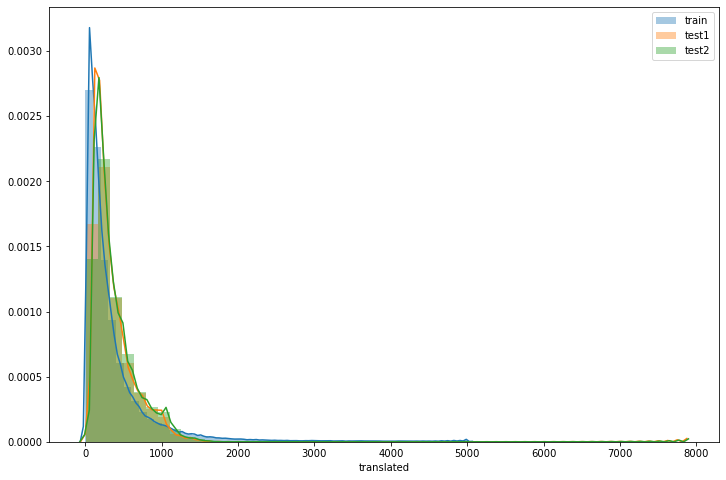

In [9]:
plt.figure(figsize=(12, 8))

sns.distplot(train1.comment_text.str.len(), label='train')
sns.distplot(test1.content_en.str.len(), label='test1')
sns.distplot(test2.translated.str.len(), label='test2')
plt.legend();

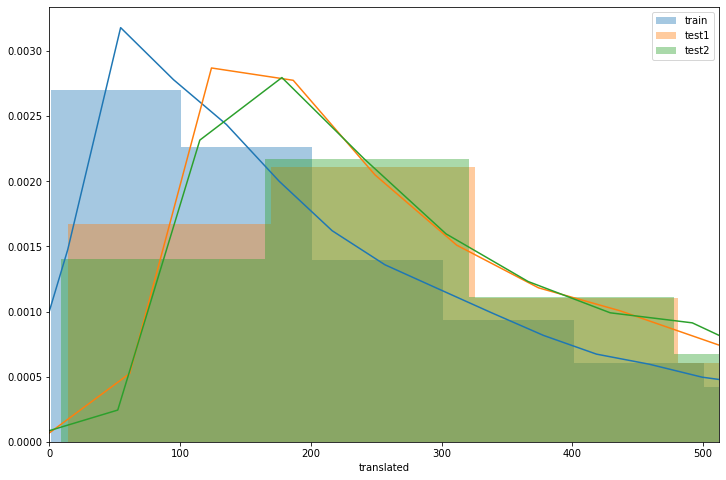

In [10]:
plt.figure(figsize=(12, 8))

sns.distplot(train1.comment_text.str.len(), label='train')
sns.distplot(test1.content_en.str.len(), label='test1')
sns.distplot(test2.translated.str.len(), label='test2')
plt.xlim([0, 512])
plt.legend();

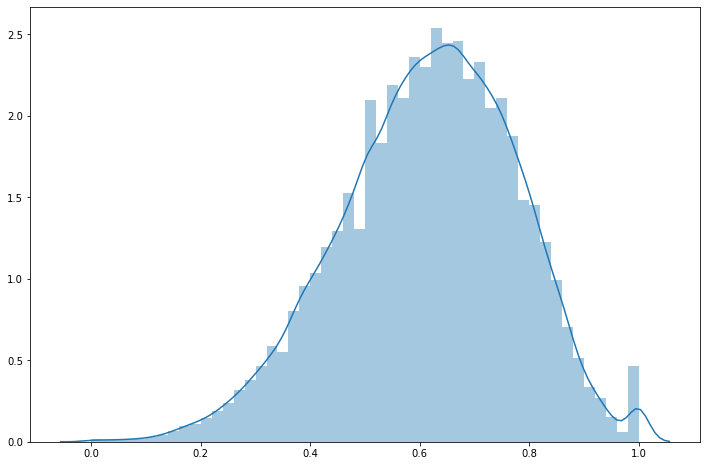

In [11]:
test_set_similarity = [cosine_sim(t1, t2) for t1, t2 in tqdm(zip(test1.content_en, test2.translated))]

plt.figure(figsize=(12, 8))

sns.distplot(test_set_similarity);

In [12]:
train = pd.concat([
    train1[['comment_text', 'toxic']],
    train2[['comment_text', 'toxic']].query('toxic==1'),
    train2[['comment_text', 'toxic']].query('toxic==0').sample(n=150000, random_state=3982)
])

## Перегоняем в понятную берту измерения

In [13]:
BATCH_SIZE = 32 * strategy.num_replicas_in_sync
MAX_LEN = 192
x_train = fast_encode(train1.comment_text.astype(str), fast_tokenizer, maxlen=MAX_LEN)
x_valid = fast_encode(valid.comment_text_en.astype(str), fast_tokenizer, maxlen=MAX_LEN)
x_test1 = fast_encode(test1.content_en.astype(str), fast_tokenizer, maxlen=MAX_LEN)
x_test2 = fast_encode(test2.translated.astype(str), fast_tokenizer, maxlen=MAX_LEN)

y_train = train1.toxic.values
y_valid = valid.toxic.values

* ## Создаем датасеты для тензорфлоу

In [14]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_train, y_train))
    .repeat()
    .shuffle(2048)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_valid, y_valid))
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

test_dataset = [(
    tf.data.Dataset
    .from_tensor_slices(x_test1)
    .batch(BATCH_SIZE)
),
    (
    tf.data.Dataset
    .from_tensor_slices(x_test2)
    .batch(BATCH_SIZE)
)]

# Создаем суррогатную функцию потерь(см https://arxiv.org/abs/1506.02626)

In [15]:
from tensorflow.keras import backend as K

def focal_loss(gamma=2., alpha=.2):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) - K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))
    return focal_loss_fixed

## Закидываем модель в ТПУ

In [16]:
%%time
with strategy.scope():
    transformer_layer = transformers.TFBertModel.from_pretrained('bert-base-uncased')
    model = build_model(transformer_layer, loss=focal_loss(gamma=1.5), max_len=MAX_LEN)
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_word_ids (InputLayer)  [(None, 192)]             0         
_________________________________________________________________
tf_bert_model (TFBertModel)  ((None, 192, 768), (None, 109482240 
_________________________________________________________________
tf_op_layer_strided_slice (T [(None, 768)]             0         
_________________________________________________________________
dropout_37 (Dropout)         (None, 768)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 769       
Total params: 109,483,009
Trainable params: 109,483,009
Non-trainable params: 0
_________________________________________________________________
CPU times: user 28.2 s, sys: 7.43 s, total: 35.6 s
Wall time: 37.8 s


## Для бинарной классификации лучше всего подойдет RocAuc  как оценщик качества классификации

In [17]:
from tensorflow.keras.callbacks import Callback 

class RocAucCallback(Callback):
    def __init__(self, test_data, score_thr):
        self.test_data = test_data
        self.score_thr = score_thr
        self.test_pred = []
        
    def on_epoch_end(self, epoch, logs=None):
        if logs['val_auc'] > self.score_thr:
            print('\nRun TTA...')
            for td in self.test_data:
                self.test_pred.append(self.model.predict(td))

# Обработчик обучения

In [18]:
def build_lrfn(lr_start=0.00002, lr_max=0.0001, 
               lr_min=0.00002, lr_rampup_epochs=7, 
               lr_sustain_epochs=0, lr_exp_decay=.87):
    lr_max = lr_max * strategy.num_replicas_in_sync

    def lrfn(epoch):
        if epoch < lr_rampup_epochs:
            lr = (lr_max - lr_start) / lr_rampup_epochs * epoch + lr_start
        elif epoch < lr_rampup_epochs + lr_sustain_epochs:
            lr = lr_max
        else:
            lr = (lr_max - lr_min) * lr_exp_decay**(epoch - lr_rampup_epochs - lr_sustain_epochs) + lr_min
        return lr
    
    return lrfn

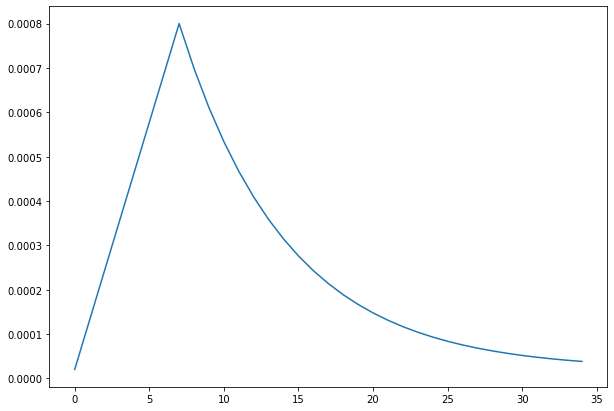

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))

_lrfn = build_lrfn()
plt.plot([i for i in range(35)], [_lrfn(i) for i in range(35)]);

## Тренируем

In [20]:
roc_auc = RocAucCallback(test_dataset, 0.8)
lrfn = build_lrfn()
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=1)
n_steps = x_train.shape[0] // BATCH_SIZE

train_history = model.fit(
    train_dataset,
    steps_per_epoch=n_steps,
    validation_data=valid_dataset,
    callbacks=[lr_schedule, roc_auc],
    epochs=30
)

Train for 873 steps, validate for 32 steps

Epoch 00001: LearningRateScheduler reducing learning rate to 2e-05.
Epoch 1/30
872/873 [============================>.] - ETA: 0s - loss: 0.0174 - auc: 0.9533
Run TTA...
873/873 [==============================] - 427s 489ms/step - loss: 0.0174 - auc: 0.9533 - val_loss: 0.0346 - val_auc: 0.9120

Epoch 00002: LearningRateScheduler reducing learning rate to 0.00013142857142857143.
Epoch 2/30
872/873 [============================>.] - ETA: 0s - loss: 0.0121 - auc: 0.9812
Run TTA...
873/873 [==============================] - 308s 352ms/step - loss: 0.0121 - auc: 0.9813 - val_loss: 0.0375 - val_auc: 0.9131

Epoch 00003: LearningRateScheduler reducing learning rate to 0.00024285714285714286.
Epoch 3/30
872/873 [============================>.] - ETA: 0s - loss: 0.0111 - auc: 0.9848
Run TTA...
873/873 [==============================] - 307s 352ms/step - loss: 0.0111 - auc: 0.9848 - val_loss: 0.0405 - val_auc: 0.8971

Epoch 00004: LearningRateScheduler

## Submission

In [21]:
sub['toxic'] = np.mean(roc_auc.test_pred, axis=0)
sub.to_csv('submission.csv', index=False)